# From Shallow to Deep Representation for multimedia database
## First Project: Lab1, Lab2, Lab3
### GONZAGA DOS SANTOS Michel

In [1]:
from os import walk
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import glob

- Recovering the name of the images from the data set

In [2]:
# Insert the data set path
mypath = "C:/Users/miche/Documents/Nouveau dossier/jpg"

# Recover paths for each image
f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break
    
g = f[0:51]

## Lab 1: Image Retrieval

Here we use the SIFT algorith, to retreive the key points and the descriptors of each image. In this part we start by creating two loops to go through the sets, one for the training set and the other one for the data set, inside these fors we calculate the key points and the descriptors for each image the methods **cv.BFMatcher** and **bf.match** look for matches between two images and then we search the results with the bigest number of matches for each pair, and keep then into a list.

In [96]:
matched_set = []
max_match = 0
for i in range(1):
    for j in range(4):
        if i != j:
            sift = cv.xfeatures2d.SIFT_create()
            kp1, des1 = sift.detectAndCompute(cv.imread(mypath+"/"+f[i],0),None)
            kp2, des2 = sift.detectAndCompute(cv.imread(mypath+"/"+f[j],0),None)
            # create BFMatcher object
            bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
            # Match descriptors.
            matches = bf.match(des1,des2)
            # Sort them in the order of their distance.
            matches = sorted(matches, key = lambda x:x.distance)
            img1_1 = cv.imread(mypath+"/"+f[i],0)
            if len(matches) > max_match:
                max_match = len(matches)
                matches_best = matches
                img2_2 = cv.imread(mypath+"/"+f[j],0)
                kp1_1 = kp1
                kp2_2 = kp2
    max_match = 0
    img3 = cv.drawMatches(img1_1,kp1_1,img2_2,kp2_2,matches_best[:10], None,flags=2)
    matched_set.append(img3)

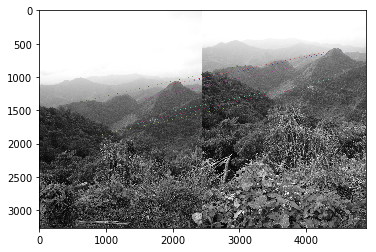

In [97]:
plt.imshow(matched_set[0])


## Lab 2: Using Bag-of-Word model to represent Images

- First we retrive the key points and descriptors of the image data set using the SFIT algorithm, in the following we store them into a list of descriptors in order to perform the second step of the Bag of Words algorithm. This part of the code was shared by BERNARD Mickael

In [4]:
sift = cv.xfeatures2d.SIFT_create()

descriptor_list = []
descriptors = []


# Reading the image and calculating the features and corresponding descriptors
for name in g[:]: #  Images
    img = cv.imread(mypath+"/"+name,0) # trainImage
    kp, des = sift.detectAndCompute(img, None)
    des = np.array(des, dtype=np.float32)
    #descriptor_list.append(des)
    descriptor_list.append((name, des))  # Appending all the descriptors into the single list
    
    
    if ( len(descriptors)==0):
        descriptors = np.array(des, dtype=np.float32)
    else:
        descriptors = np.vstack((descriptors, np.array(des)))

In this part we perform the Cluster K-means algorithm, the paramtters chosen in this part are:
<br>
- K = 200
<br>
- iterations = 10 
<br>
- epsilon = 1.0
<br>
The criteria was chosen by defaut as: criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, iterations, epsilon). This part of the code was shared by BERNARD Mickael 

In [5]:
K = 200 #" Number of clusters"

iterations = 10
epsilon = 1.0
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, iterations, epsilon)

# Apply K-means
ret,labels,centers=cv.kmeans(descriptors,K,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)
#compactness : It is the sum of squared distance from each point to their corresponding centers.
#labels : This is the label array (same as 'code' in previous article) where each element marked '0', '1'.....
#centers : This is array of centers of clusters.

Given that we have the clusters the next step is bild the histograms that will represent the Bag of words for each image. First, it is important to understand that each cluster represents a visual word and in terms of this histograms, each bin will represent the number of features that were calssified at the corresponding cluster,i.e visual word. This part of the code was shared by BERNARD Mickael. 

In [6]:
im_features = np.zeros((len(g[:]), K), "float32")
im_num_descriptors = np.zeros(len(g[:]))

y = 0
for i in range(len(g[:])): # For every image
    
    
    words = descriptor_list[i][1]
    for w in words: # For every descriptor associated to the image
        cluster = labels[y]

        #print(y)
        #print(cluster)
        im_features[i][cluster] += 1
        y += 1
        

    im_num_descriptors[i] = np.count_nonzero(im_features[i])


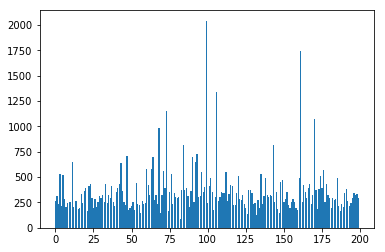

In [7]:
plt.bar([i for i in range(K)],im_features[0])
plt.show()

- TF(Terme Frequency):
<br>
Here we calculate the terme frequency, to do so we use the fact that the vectors im_features used to obtain the histograms contain the number of each word in each image, than we divide them by the total number of descriptors the related image

In [8]:
TF = np.zeros((len(g[:]), K), "float32")
for i in range(len(g)):
    ds = descriptor_list[i][1]
    dim = ds.shape
    TF[i] = np.array(im_features[i])/(dim[0]*dim[1])

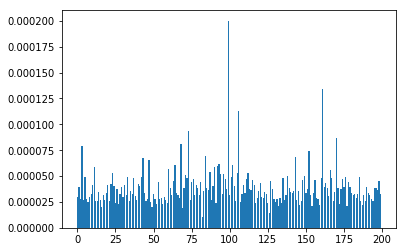

In [9]:
plt.bar([i for i in range(K)],TF[1])
plt.show()

Here we calculate the IDF based on the fact that all the vectors im_features have the same legnth so we make a sort of comparation between the elements of these vectors and obtain the number of images containig the word by counting the number of vectors whose component related to this word is different of zero

In [10]:
IDF = np.zeros( K, "float32")
s = 0
for j in range(K):
    for i in range(len(g[:])):
        vec_hist = im_features[i]
        if vec_hist[j] != 0: 
            s = s + 1
    IDF[j] = np.log10(K/s)
    s = 0

- TF-IDF:
<br>
The value of tf-idf is given by the product between TF an IDF for each bag of words ass a resul we have a sort of, normalized bag of words. This is done multiplying component by component of the vectors TF[i] and IDF. 

In [11]:
TF_IDF = np.zeros((len(g[:]), K), "float32")
for i in range(len(g[:])):
    vec_tf = TF[i]
    for j in range(K):
        vec_tf[j] = vec_tf[j]*IDF[j]
    TF_IDF[i] = vec_tf 

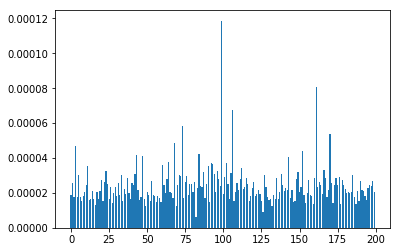

In [12]:
plt.bar([i for i in range(K)],TF_IDF[1])
plt.show()

The Inverted image index part is shown in pice of code bellow. Basically our stategy was give the vectors used to plot the histograms, for each component retrieve and storage the images in the data set that contain this component

In [13]:
# Here our task is to perfom the inverted image index
from collections import defaultdict
   
inv_indx = defaultdict(list)        
for j in range(K):
    for i in range(len(g[:])):
        vec_hist = im_features[i]
        if vec_hist[j] != 0: 
            inv_indx[j].append(f[i])

Given a Query image our goal now is to retrive the matches using the Bag of Words obtained in the previous part. The part of the code bellow is responsable to determine to what clusters belongs each descriptor of the image, as a result we have a new bag of Words that will be compared to the Inverted image index in order to retrive the matches. This part of the code was shared by BERNARD Mickael.   

In [14]:
## Retrouver le cluster auquel appartient un descripteur à partir de la position du centre du cluster:
import math
# Find the closest cluster
from scipy.spatial import distance

def closest_cluster(clusters, points):
    labels = np.zeros(len(points))
    j = 0
    for point in points:
        distances = np.zeros(len(clusters)) 
        i= 0
        for cluster in clusters:
            values = zip(point,cluster)
            diffs_squared_distance = [pow(a - b, 2) for (a, b) in values]
            distances[i] = math.sqrt(sum(diffs_squared_distance))
            i += 1
        labels[j] = np.argmin(distances)
        j +=1
        
    return labels

We may chose a Query image out of the training set in order to find the most similiar one inside the data set. 

In [15]:
# Query image
img = cv.imread(mypath+"/"+f[51],0) # trainImage
kp, des = sift.detectAndCompute(img, None)
des = np.array(des, dtype=np.float32)
predict = closest_cluster(centers, des)

101901.jpg


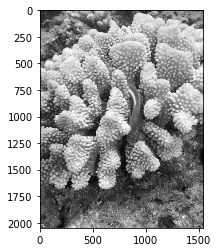

In [16]:
print(f[51])
plt.imshow(img,cmap= 'gray')

Given the result of the method **closest_cluster**, i.e the lables what we do is eliminate the repetitions in order to obtain the the visual words the bellong to the image

In [17]:
clusters = set([x for x in predict if (predict.tolist()).count(x) > 1])
clusters = list(clusters)


In this part of the code we are supossed to use the information that we have about the lables for the querry image and the inverted index to buit a sort of seaching structure. In the first for we take the out put of the previous piece of code and compare it with the im_features, if the value of imafeatues[cluster[l]] is different of zero than we keep the related images using the Inversed Indexed. In the second we cont the number of times that each image occurs in the list index, that considers all the cluster. The last for is dedicated to keep the the images that occure the most, in order retrive the most relevant images, to do so we keep the image where the number of occureces is equal to the maximum of the set.

In [18]:

image_priority = np.zeros(len(g))
index = []
relevant = []
for l in range(len(clusters)):
    for i in range(len(g[:])):
        vec_hist = im_features[i]
        a = int(clusters[l])
        if vec_hist[a] != 0: 
            index = index + inv_indx[a]

for n in range(len(g)):
    cont = 0
    for m in range(len(index)):
        if g[n] == index[m]:
            cont = cont + 1
    image_priority[n] = cont
    
for w in range(len(g)):   
    if image_priority[w]== max(image_priority):
        relevant.append([g[w],im_features[w]]) 
   

Here we bild the histogram that reppresents the bag of words o the Query image using the predicted lables, by counting their number of occurences separetly. 

In [19]:
query_hist = np.zeros(K,'float32')
for i in range(K):
    y = 0
    for j in range(len(predict)):
        if predict[j] == i:
            y = y + 1
    query_hist[i] = y

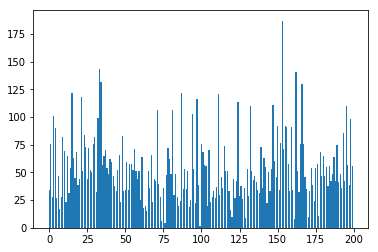

In [20]:
plt.bar([i for i in range(K)],query_hist)
plt.show()

This part of the code concludes the Inverted Index strategy, given the list of relevant images what we do is to compare their Bag of Words with the Query's one. This comparation of then is performed by the the sum of the absolute value of difference between bins of the Bag of Words normalized by their maximum value, in order to work with valeus at the same scale.

In [22]:
diff = np.zeros(K,'float32')
list_diff = []
for i in range(len(relevant)):
    vec = relevant[i][1]
    for j in range(len(query_hist)):
        if query_hist[j] !=0 and vec[j] !=0:
            diff[j] = abs(query_hist[j]/max(query_hist) - (vec[j]/max(vec)))
    list_diff.append([relevant[i][0],np.sum(diff)])

Then to retrive the best match we take the image related to des smallest component of the list_diff 

101900.jpg


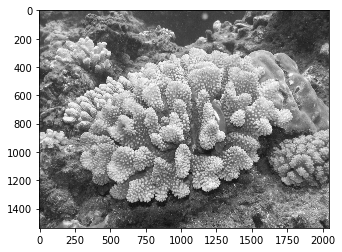

In [23]:
mini = float('inf')

for i in  range(len(vec_diff)):
    if vec_diff[i][1] < mini:
        match_id = vec_diff[i][0]
        mini = vec_diff[i][1] 
print(match_id)
img_rec = cv.imread(mypath+"/"+match_id,0)
plt.imshow(img_rec,cmap= 'gray')

## Lab 3: Using Deep Networks to represent Images
<br> 
<br>
Here we start by importing a pre trained neural network named VGG16, from keras

In [3]:
from keras.applications import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224,3))

C:\Users\miche\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In this part we freeze the layers except for layer 4 

In [4]:
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000002094AED5588> False
<keras.layers.convolutional.Conv2D object at 0x000002094AD78E10> False
<keras.layers.convolutional.Conv2D object at 0x000002094AD78C88> False
<keras.layers.pooling.MaxPooling2D object at 0x000002094AD9B710> False
<keras.layers.convolutional.Conv2D object at 0x000002094AD9BF60> False
<keras.layers.convolutional.Conv2D object at 0x000002094ADDC240> False
<keras.layers.pooling.MaxPooling2D object at 0x000002094ADF65C0> False
<keras.layers.convolutional.Conv2D object at 0x000002094ADF69E8> False
<keras.layers.convolutional.Conv2D object at 0x000002094AE293C8> False
<keras.layers.convolutional.Conv2D object at 0x0000020950B167B8> False
<keras.layers.pooling.MaxPooling2D object at 0x0000020950B350B8> False
<keras.layers.convolutional.Conv2D object at 0x0000020950B359E8> False
<keras.layers.convolutional.Conv2D object at 0x0000020950B693C8> False
<keras.layers.convolutional.Conv2D object at 0x0000020950B837B8> False
<ker

In this part we select an image from the list of files f, that will be used as the input of the neural network. We redefine the dimensions of the image in order to fit the model, rigth in the following we use the function **np.expand_dims()** to exapand the dimensions of the image, to than move to the image preprocess. The features are the result of predictions of the model for the input image.

In [5]:
img = image.load_img(mypath+"/"+f[0], target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
features = vgg_conv.predict(x)